**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [19]:
#!pip install wordcloud

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [80]:
# Set the style for seaborn
sns.set(style="white")

In [71]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

In [72]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [73]:
# Set id as index
df_test.set_index('id', inplace=True)

In [74]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [75]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

In [76]:
df_train["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [77]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

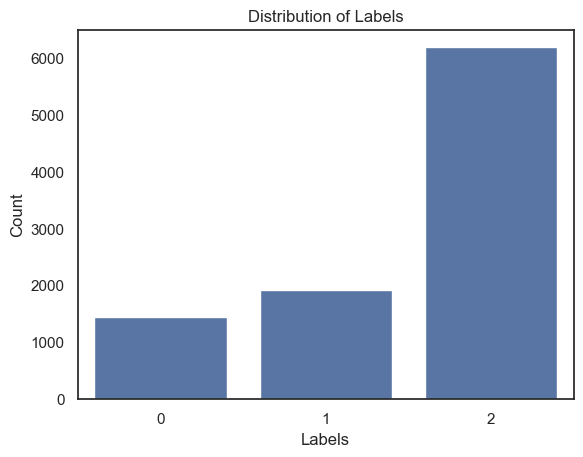

In [78]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

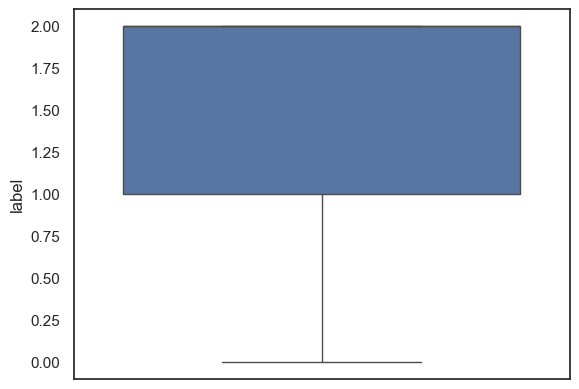

In [95]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

In [83]:
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [84]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

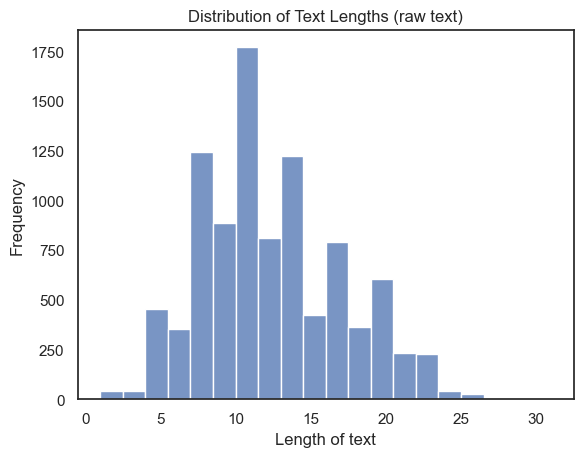

In [96]:
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [86]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

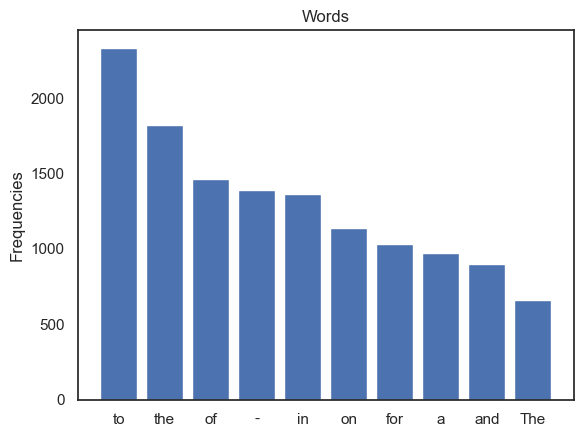

In [89]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

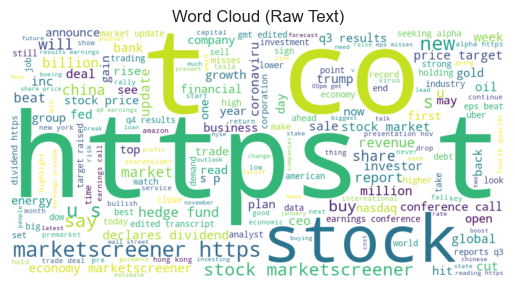

In [90]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

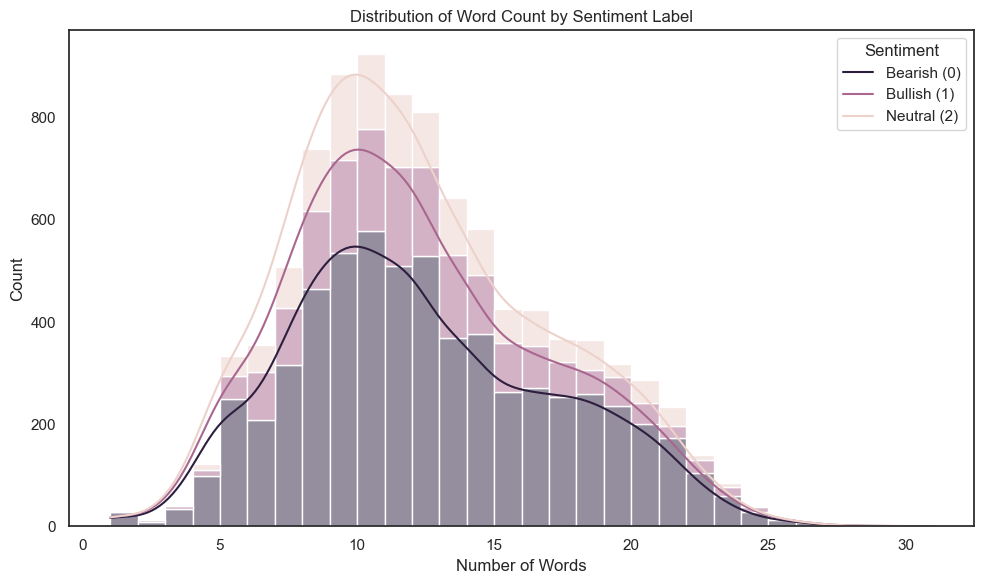

In [92]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

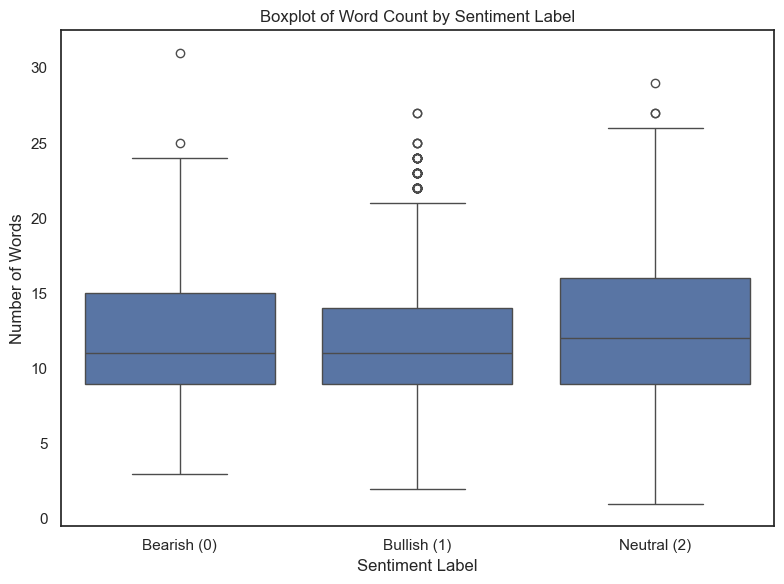

In [97]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [98]:
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [99]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

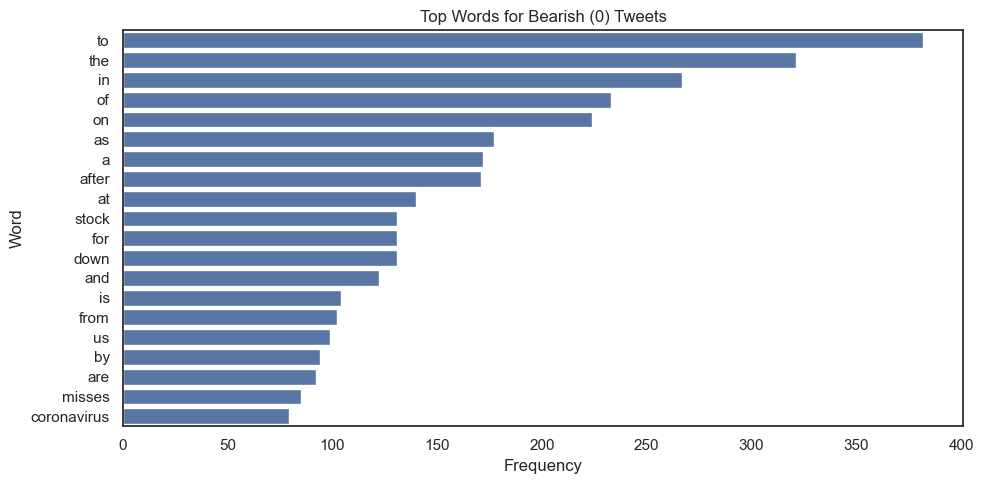

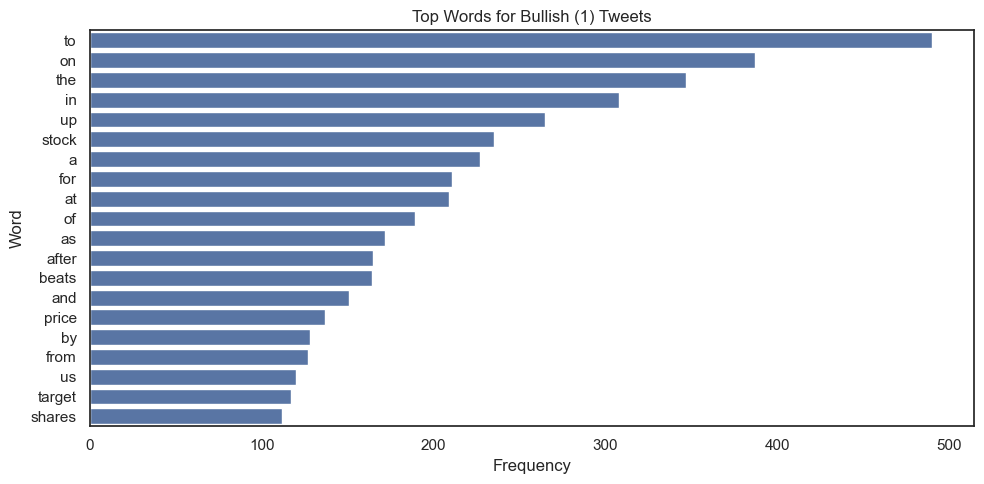

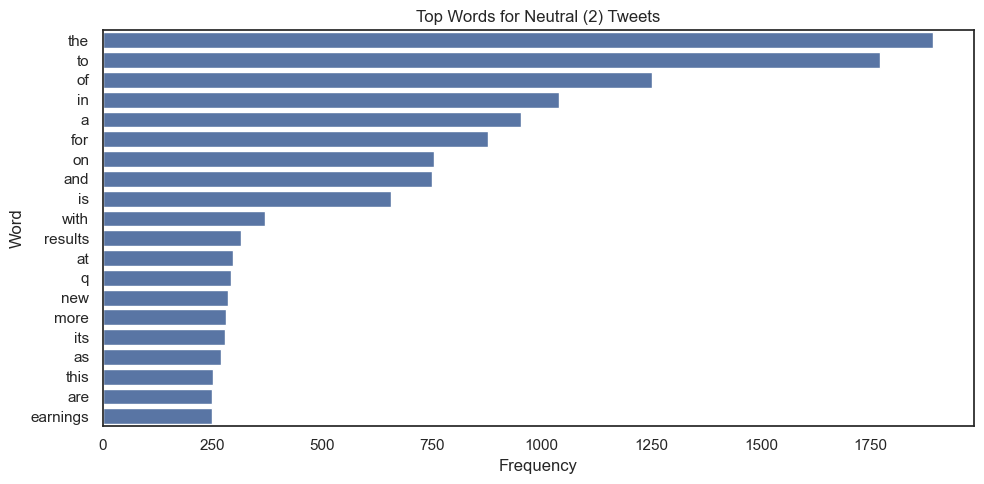

In [100]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [101]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

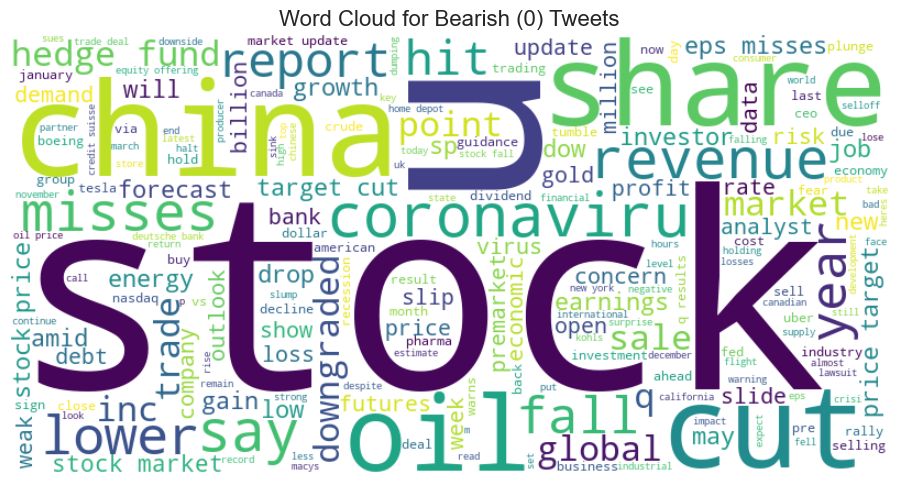

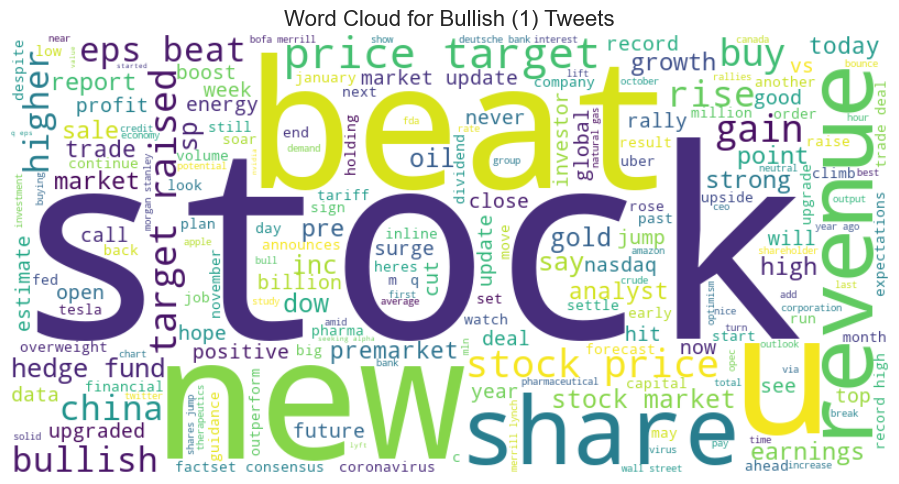

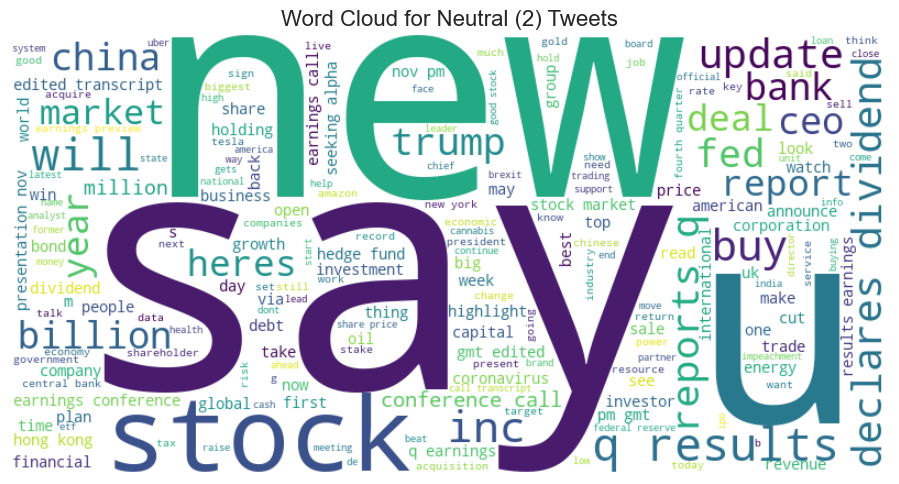

In [102]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

In [103]:
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)

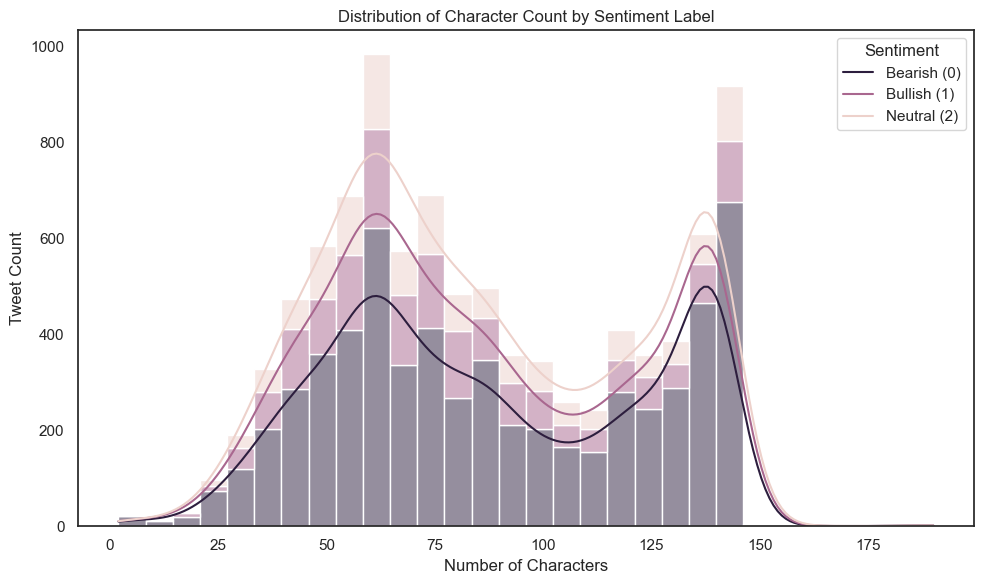

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

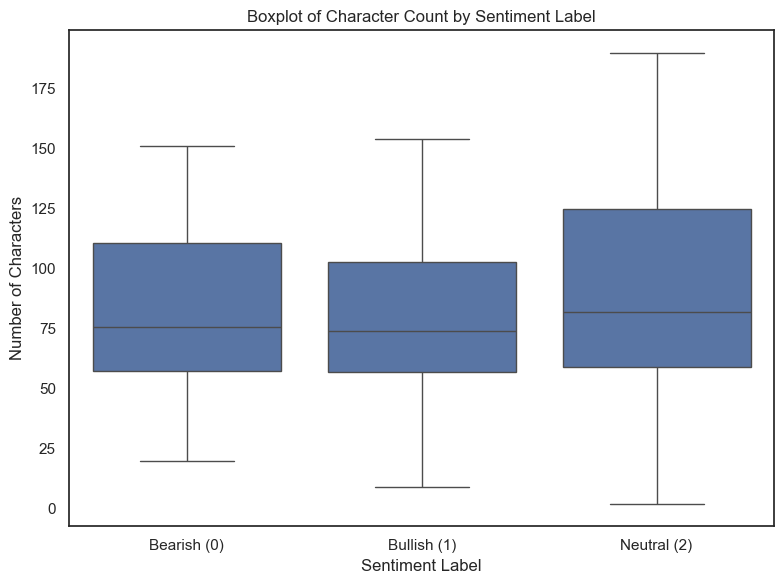

In [105]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [108]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [109]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

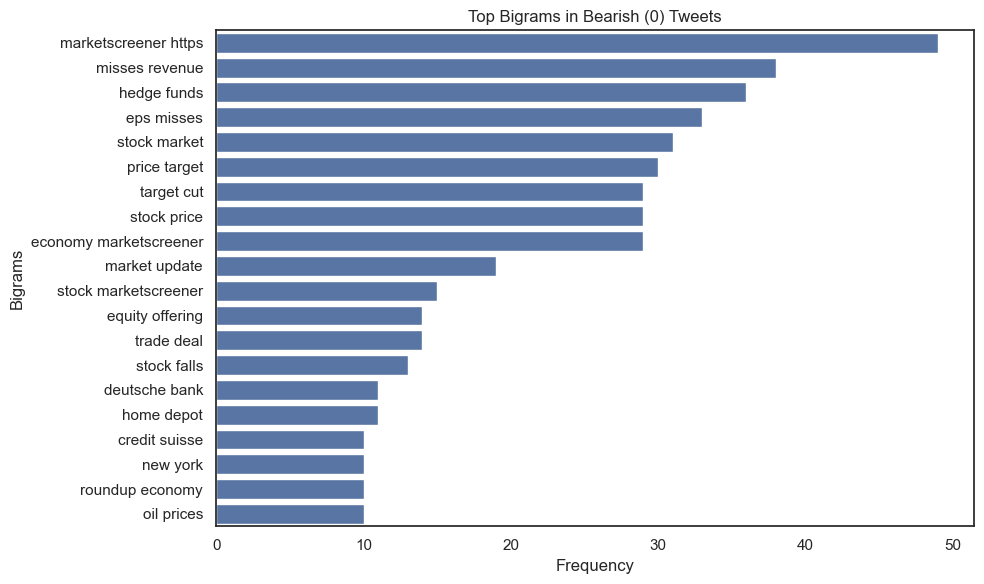

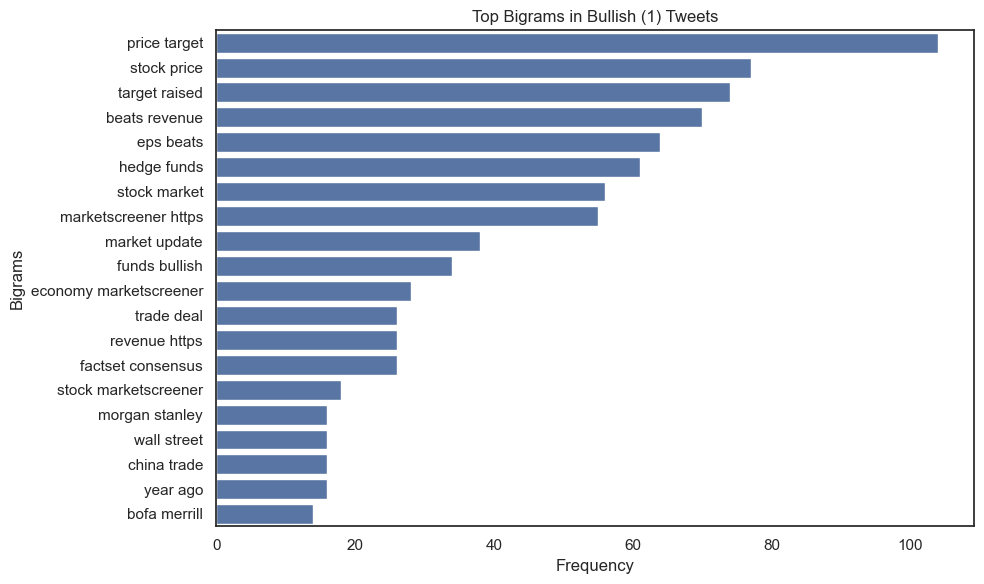

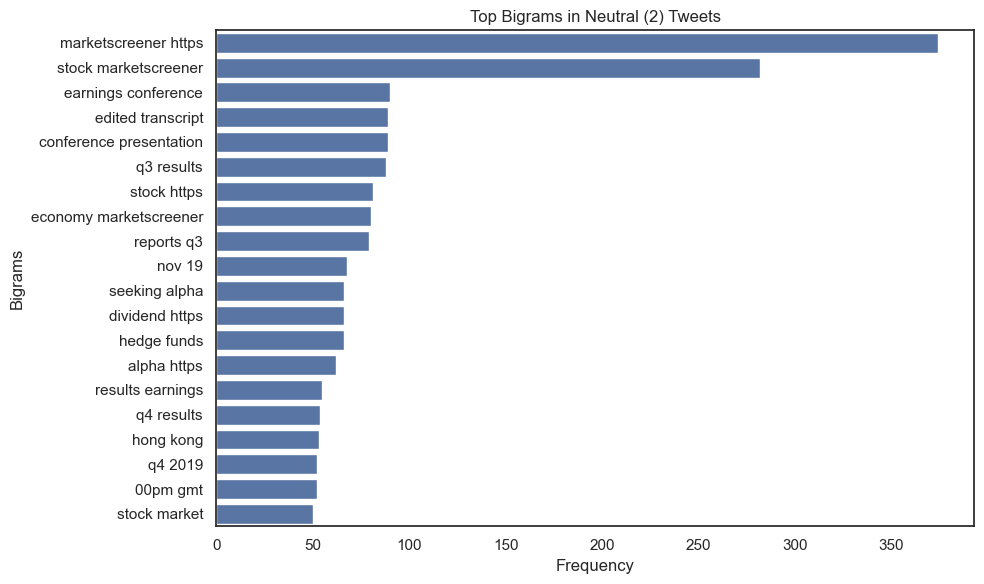

In [111]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

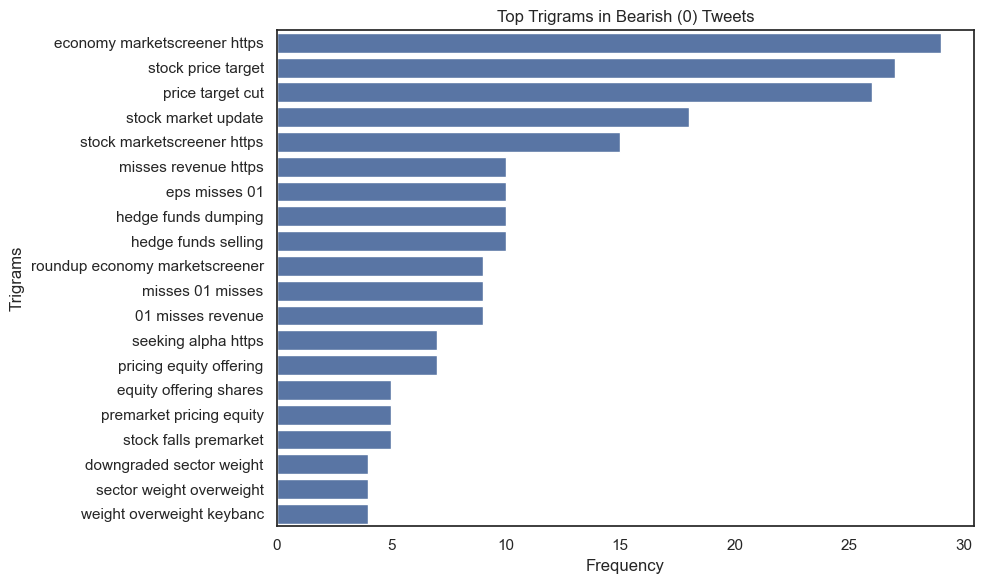

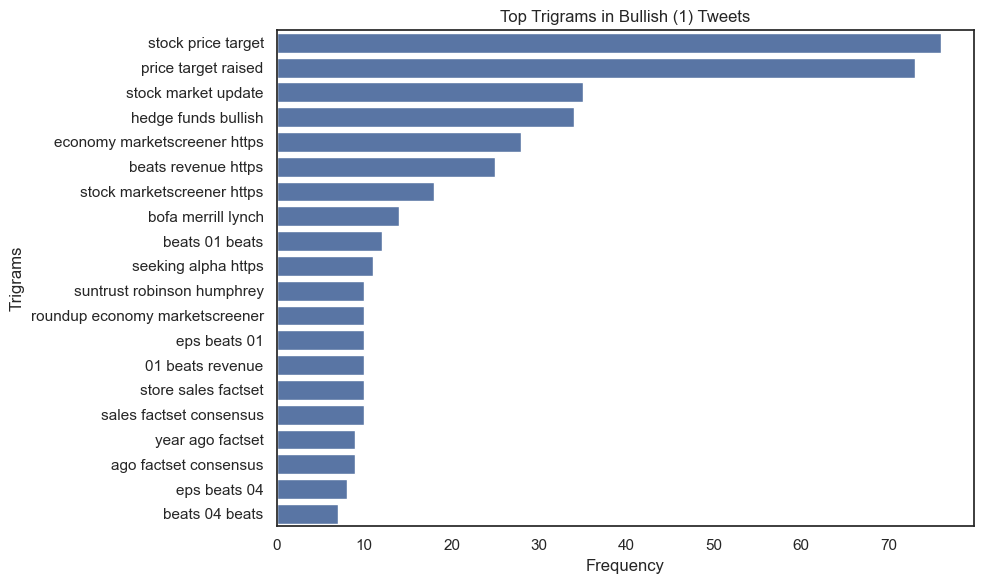

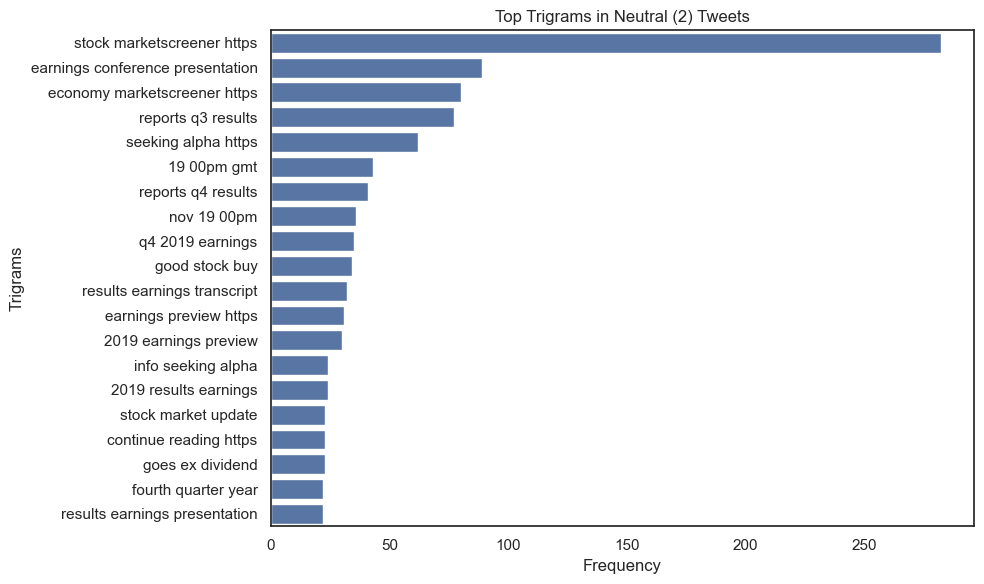

In [112]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

In [113]:
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms

In [116]:
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

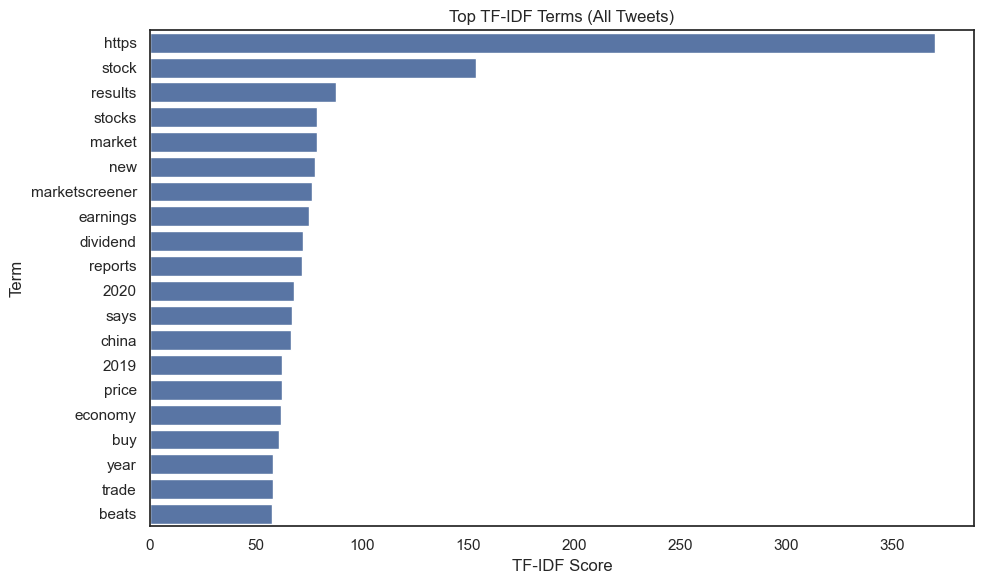

In [117]:
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')

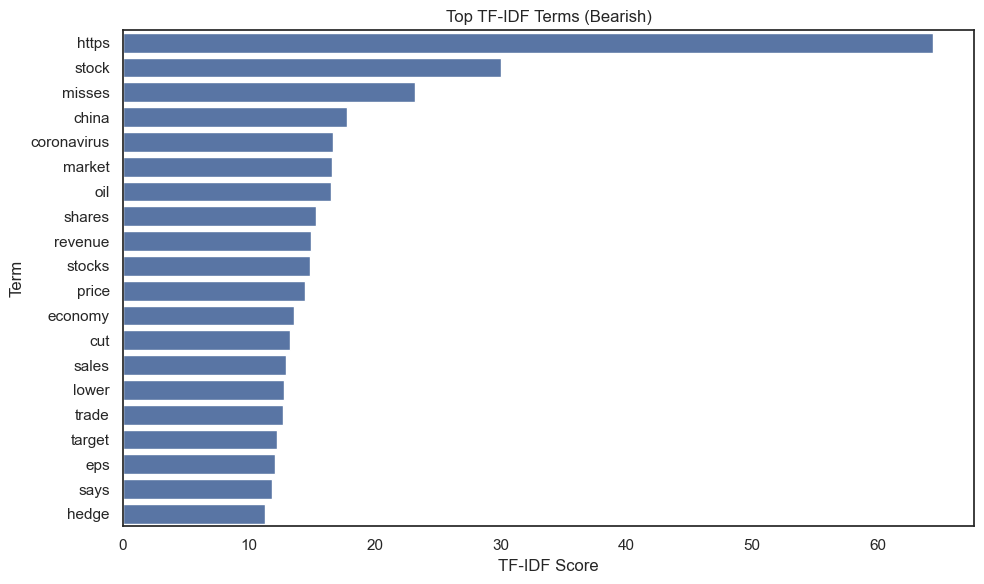

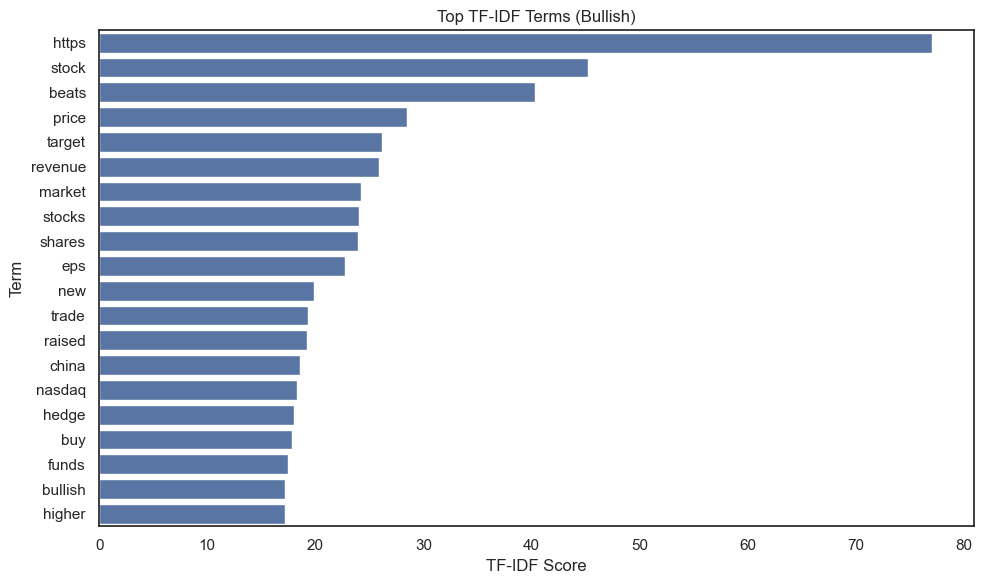

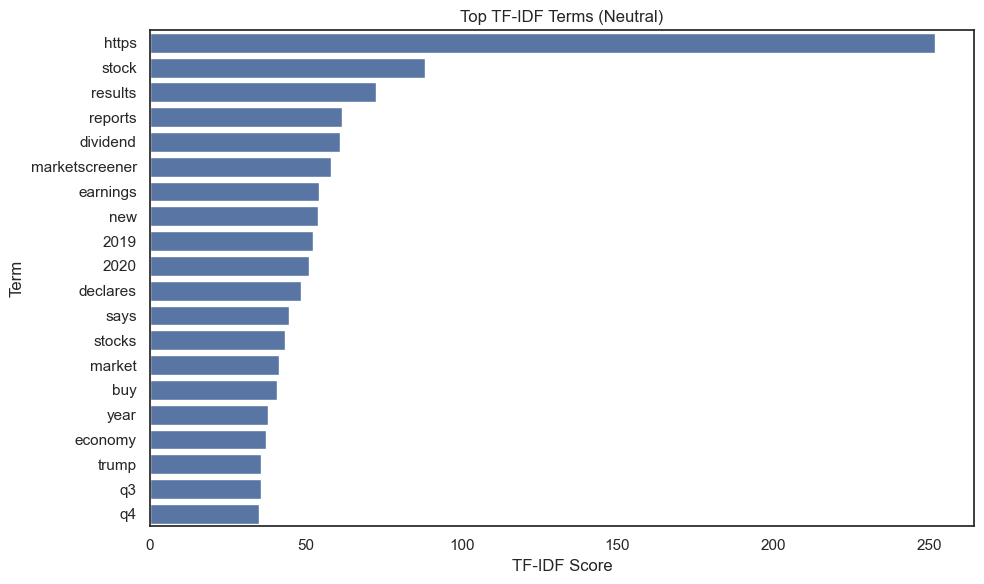

In [118]:
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')